In [1]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np 
import random 
import os 

In [2]:
import sys
print(sys.version)


3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]


In [3]:
a = np.array([2,32])
print(a[0])

2


In [4]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [ ]:
# !tar -xf negative.tgz

In [ ]:
# Move LFW Images to the following repository data/negative
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

In [ ]:
# Import uuid library to generate unique image names
import uuid

In [ ]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

In [ ]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:370,200:450, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [ ]:
plt.imshow(frame[120:120+250,200:200+250, :])

In [ ]:
import tensorflow as tf 
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [ ]:
import os
import uuid

In [ ]:
img_path = os.path.join(ANC_PATH, '924e839c-135f-11ec-b54e-a0cec8d2d278.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [ ]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [6]:
import tensorflow as tf 

In [7]:
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Layer , Conv2D , Dense , MaxPooling2D ,Input , Flatten

In [ ]:
# Model(inputs = [inputimage , verificationimage] , outputs=[1,0])

In [8]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)
# anchor = tf.data.Dataset.list_files(ANC_PATH + '\\*.jpg').take(50)
# positive = tf.data.Dataset.list_files(POS_PATH + '\\*.jpg').take(50)
# negative = tf.data.Dataset.list_files(NEG_PATH + '\*.jpg').take(30)

In [9]:
dir_test = anchor.as_numpy_iterator()
dir_test.next()


b'data\\anchor\\db31894d-4eb5-11ef-9327-d3400457995b.jpg'

In [10]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)

    # preprocessing image to 100 * 100 pixels * 3 channels 
    img = tf.image.resize(img , (100 , 100))
    #scale image between 0 to 1
    img = img/255.0 

    return img 

In [11]:
img = preprocess('data/anchor/007518c6-4ea8-11ef-8c51-d3400457995b.jpg')

In [ ]:
img.numpy().max()

In [ ]:
plt.imshow(img) 

In [ ]:
dataset.map(preprocess)

In [ ]:
class_labels = tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))

In [ ]:
iterator_labs = class_labels.as_numpy_iterator()

In [ ]:
iterator_labs.next()

In [ ]:
# create labelled dataset

In [12]:
# (anchor , positive)  = > 1,1,1,1 ,1
# (anchor , positive)  = > 0,0,0,0,0

positives = tf.data.Dataset.zip((anchor , positive , tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor , negative , tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data =  positives.concatenate(negatives)

In [13]:
samples = data.as_numpy_iterator()
ex = samples.next() 

In [14]:
# build test and train partition 

In [15]:
def preprocess_twin(input_img , validation_img , label):
    return (preprocess(input_img), preprocess(validation_img) , label)

In [16]:
res = preprocess_twin(*ex)

In [17]:
len(res)

3

In [18]:
# build dataloader pipeline

data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size =10000)


In [19]:
samples = data.as_numpy_iterator()
len(samples.next())

3

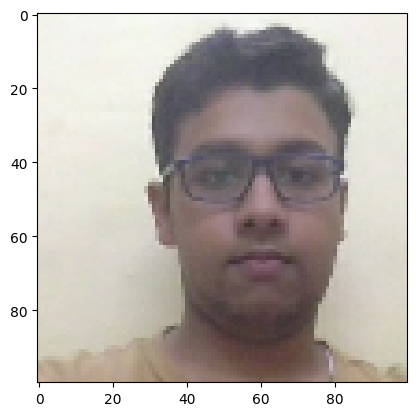

In [21]:
samp = samples.next()
plt.imshow(samp[0])

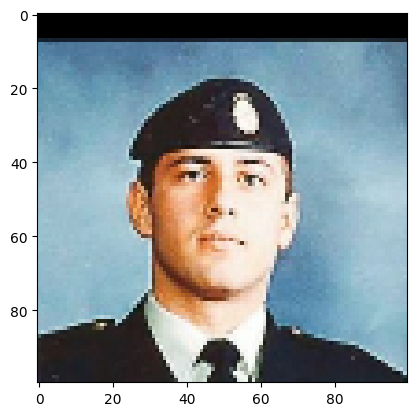

In [22]:
plt.imshow(samp[1])

In [23]:
samp[2]

0.0

In [24]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [25]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [26]:
# formation of model 

In [ ]:
inp = Input(shape=(100,100,3) ,name='input_image')

In [ ]:
inp 

In [ ]:
c1 = Conv2D(64,(10,10) , activation='relu')(inp)

In [ ]:
c1

In [ ]:
m1 = MaxPooling2D(64,(2,2),padding='same')(c1)

In [ ]:
m1

In [27]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')
    #first block
    c1 = Conv2D(64,(10,10) , activation='relu')(inp)
    m1 = MaxPooling2D(64,(2,2),padding='same')(c1)
    #second block
    c2 = Conv2D(128,(7,7) , activation='relu')(m1)
    m2 = MaxPooling2D(64,(2,2),padding='same')(c2)
    #third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=[inp] , outputs=[d1] , name='embedding') 

In [28]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# THIS IS CUSTOM LAYER WHICH IS THE DEFINING CHAR IN siamese network 

In [29]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__(**kwargs)

    def call(self, input_embedding, validation_embedding):
        
        input_tensor = input_embedding[0]  # Assuming you need the first tensor in the list
        validation_tensor = validation_embedding[0]  # Assuming you need the first tensor in the list
    
        # Perform the subtraction
        return tf.math.abs(input_tensor - validation_tensor)

    def compute_output_shape(self, input_shape):
        return input_shape[0]


In [30]:
l1 = L1Dist()

In [ ]:
l1(anchor_embedding , validation_embedding)

In [31]:
def make_siamese_model(): 
    # Anchor image input in the network
    input_image = tf.keras.layers.Input(name='input_img', shape=(100, 100, 3))
    
    # Validation image in the network 
    validation_image = tf.keras.layers.Input(name='validation_img', shape=(100, 100, 3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = tf.keras.layers.Dense(1, activation='sigmoid')(distances)
    
    return tf.keras.Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [32]:
siamese_model = make_siamese_model()

In [33]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_1 (L1Dist)            │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# TRAIN MODEL 

In [34]:
# LOSS function 
binary_cross_loss = tf.losses.BinaryCrossentropy()

# optimizer

opt = tf.keras.optimizers.Adam(1e-4) # .0001

In [43]:
# establish checkpoints 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)


In [44]:
EPOCHS = 50 

In [45]:
# # basic flow 
# prediction 
# loss 
# gradient 
# new weights 

In [46]:
test_batch = train_data.as_numpy_iterator()

In [47]:
batch_1 = test_batch.next()

In [48]:
len(batch_1)
batch_1[0]
len(batch_1[0])
batch_1[2]


array([0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [ ]:
X = batch[:2]

In [ ]:
X

In [ ]:
y = batch[:2]

In [ ]:
y

In [49]:
# compiles a function into a callable tensorflow graph 
@tf.function
def train_step(batch):
    # tf.Gradient allows us to record operation for automatic differentiation 
    with tf.GradientTape() as tape : 
        # get anchor and positive /negative image 
        X = batch[:2]
        # get label 
        y = batch[:2]

        # forward pass 
        yhat = siamese_model(X , training= True)
        if isinstance(y, tuple):
            y = y[0]  # Extract the tensor from the tuple if needed
        if isinstance(yhat, tuple):
            yhat = yhat[0]  # Extract the tensor from the tuple if needed
        # loss
        loss = binary_cross_loss(y , yhat)
    print(loss)
        # calculating gradients 
    grad = tape.gradient(loss , siamese_model.trainable_variables)
        # calculate updated weights and apply to siamese model 
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
        
        
    return loss 
def train_step(batch):
    X = batch[:2]  # Assuming X is properly extracted
    y = batch[2]   # Assuming y is the third element in the batch
    yhat = siamese_model(X, training=True)

    # Ensure y and yhat are tensors
    if isinstance(y, tuple):
        y = y[0]  # Extract the tensor from the tuple if needed
    if isinstance(yhat, tuple):
        yhat = yhat[0]  # Extract the tensor from the tuple if needed

    loss = binary_cross_loss(y, yhat)
    print(loss)

    # Assuming there's more code to update gradients, optimizer, etc.


In [50]:
def train(data, EPOCHS):
    #loop through the epochs 
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch,EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

# loop through each batch

    for idx , batch in enumerate(data):
        # run train step here 
        train_step(batch)
        progbar.update(idx+1)

    # save checkpoints
    if epoch % 10 == 0 :
        checkpoint.save(file_prefix=checkpoint_prefix)
        
        
        

In [51]:
train(train_data, EPOCHS)
# HERE to also print the loss defined above we need eager execution 



 Epoch 1/50

 Epoch 2/50

 Epoch 3/50

 Epoch 4/50

 Epoch 5/50

 Epoch 6/50

 Epoch 7/50

 Epoch 8/50

 Epoch 9/50

 Epoch 10/50

 Epoch 11/50

 Epoch 12/50

 Epoch 13/50

 Epoch 14/50

 Epoch 15/50

 Epoch 16/50

 Epoch 17/50

 Epoch 18/50

 Epoch 19/50

 Epoch 20/50

 Epoch 21/50

 Epoch 22/50

 Epoch 23/50

 Epoch 24/50

 Epoch 25/50

 Epoch 26/50

 Epoch 27/50

 Epoch 28/50

 Epoch 29/50

 Epoch 30/50

 Epoch 31/50

 Epoch 32/50

 Epoch 33/50

 Epoch 34/50

 Epoch 35/50

 Epoch 36/50

 Epoch 37/50

 Epoch 38/50

 Epoch 39/50

 Epoch 40/50

 Epoch 41/50

 Epoch 42/50

 Epoch 43/50

 Epoch 44/50

 Epoch 45/50

 Epoch 46/50

 Epoch 47/50

 Epoch 48/50

 Epoch 49/50

 Epoch 50/50
tf.Tensor(0.692564, shape=(), dtype=float32)
 1/27 ━━━━━━━━━━━━━━━━━━━━ 1:26 3s/steptf.Tensor(0.69301134, shape=(), dtype=float32)
 2/27 ━━━━━━━━━━━━━━━━━━━━ 3:16 8s/steptf.Tensor(0.6930387, shape=(), dtype=float32)
 3/27 ━━━━━━━━━━━━━━━━━━━━ 2:57 7s/steptf.Tensor(0.69283867, shape=(), dtype=float32)
 4/27 ━

In [ ]:
# evaluate models 


In [85]:
# import metrics 

# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [86]:
# get a batch of test data 
test_input , test_val ,y_true = test_data.as_numpy_iterator().next()


In [87]:
test_var = test_data.as_numpy_iterator().next()


In [88]:
len(test_var[1])
test_var[1]

array([[[[0.9267157 , 0.9286765 , 0.85808825],
         [0.9196078 , 0.9279412 , 0.8629902 ],
         [0.92107844, 0.92941177, 0.8718137 ],
         ...,
         [0.9406863 , 0.9698529 , 0.89411765],
         [0.9431372 , 0.9745098 , 0.8835784 ],
         [0.9313725 , 0.9627451 , 0.8686274 ]],

        [[0.90906864, 0.92769605, 0.860049  ],
         [0.90931374, 0.9279412 , 0.8607843 ],
         [0.9107843 , 0.92941177, 0.86813724],
         ...,
         [0.9404412 , 0.95710784, 0.8875    ],
         [0.94460785, 0.9642157 , 0.87990195],
         [0.94803923, 0.9676471 , 0.8784314 ]],

        [[0.89411765, 0.9235294 , 0.8519608 ],
         [0.89436275, 0.9218137 , 0.8517157 ],
         [0.8953431 , 0.9227941 , 0.8541667 ],
         ...,
         [0.94289213, 0.95955884, 0.889951  ],
         [0.94534314, 0.964951  , 0.88504905],
         [0.9470588 , 0.96666664, 0.8862745 ]],

        ...,

        [[0.84460783, 0.8495098 , 0.7681373 ],
         [0.8365196 , 0.84142154, 0.76004905]

In [89]:
test_val 
test_input 
y_true 


array([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0.],
      dtype=float32)

In [90]:
# make prediction 
y_hat = siamese_model.predict([test_input , test_val])
y_hat


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


array([[0.49907044],
       [0.49678588],
       [0.499382  ],
       [0.49789438],
       [0.4997674 ],
       [0.4984607 ],
       [0.498589  ],
       [0.4985511 ],
       [0.4986241 ],
       [0.49964976],
       [0.49648005],
       [0.49944127],
       [0.49910057],
       [0.4997492 ],
       [0.49668708],
       [0.49729773]], dtype=float32)

In [91]:
# post processing 
[1 if prediction >0.5 else 0 for prediction in y_hat ] 


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# res =[]

# for prediction in y_hat:
#     if prediction >0.5:
#         res.append(1)
#     else:
#         res.append(0)

# can also be done like this 

        
        

In [79]:
y_true

array([0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1.],
      dtype=float32)

In [ ]:
# creating a metric object 
m = Recall()
# calculating the recall value 
m = update_state(y_true , y_hat)
# return recall result 
m.result().numpy()


In [ ]:
# plotting the results 


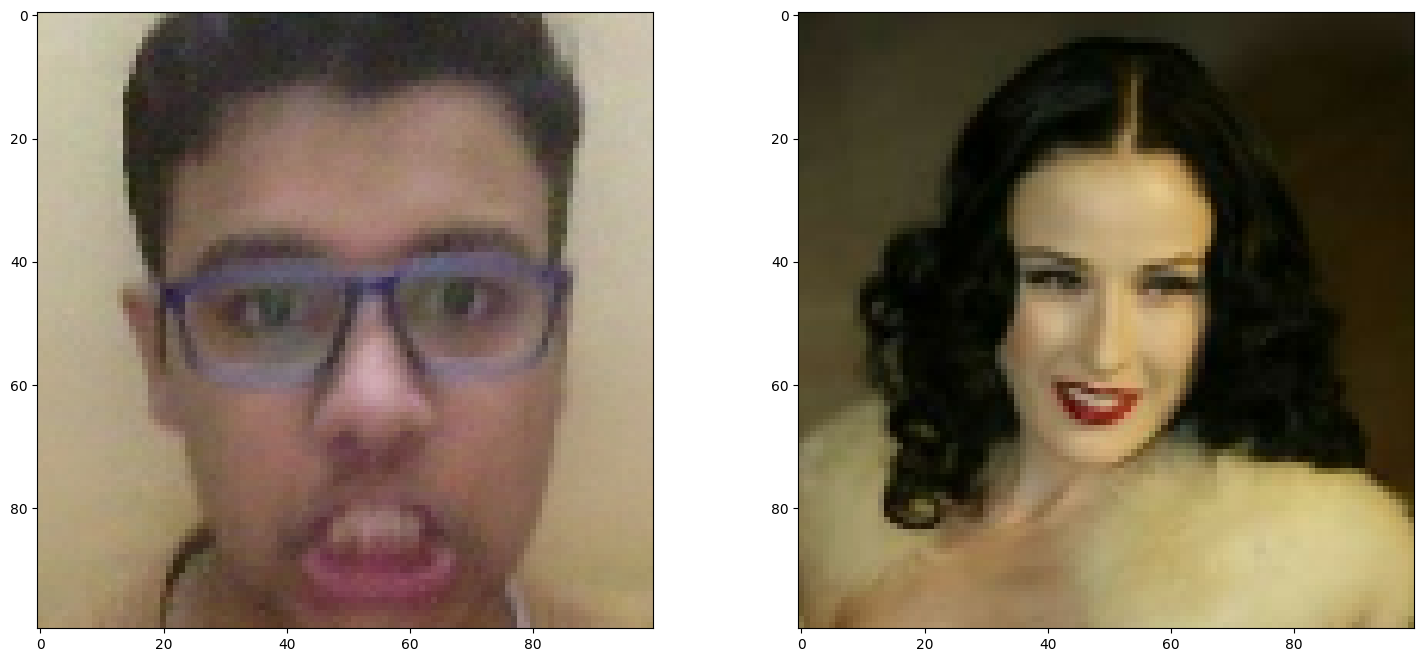

In [80]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[0])
plt.subplot(1,2,2)
plt.imshow(test_val[0])
plt.show()

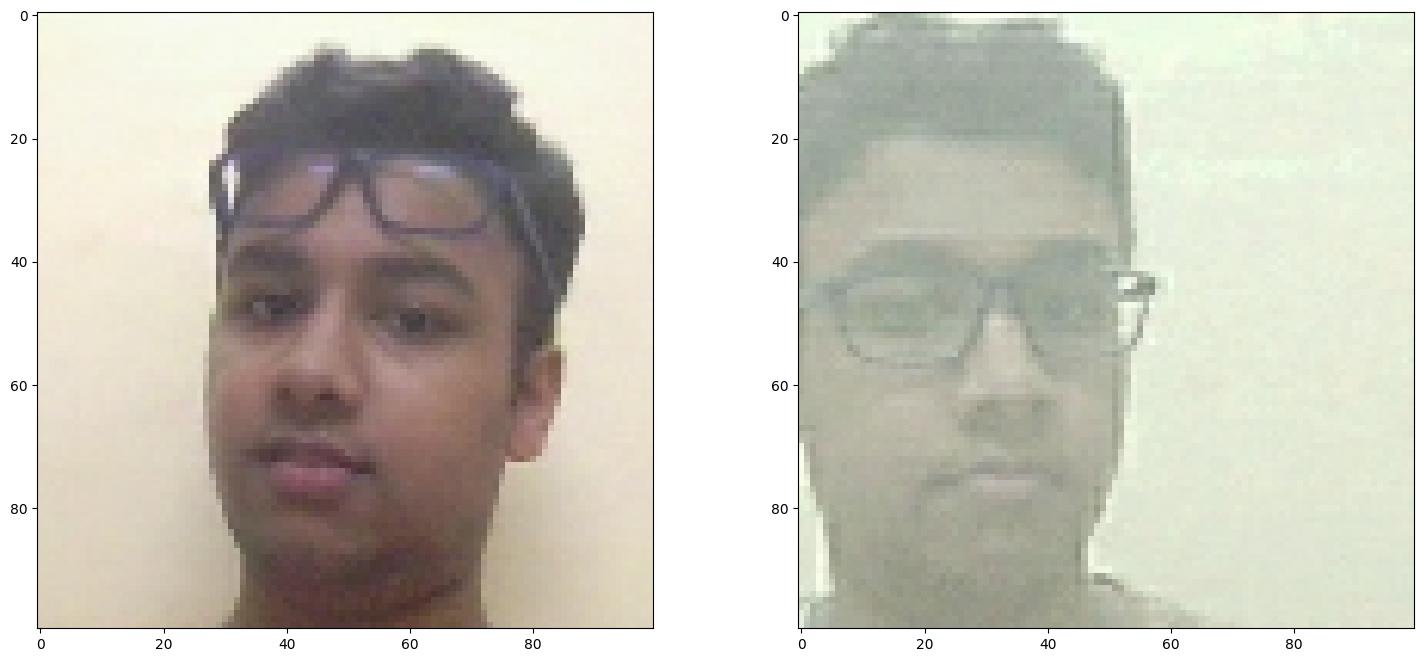

In [81]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[7])
plt.subplot(1,2,2)
plt.imshow(test_val[7])
plt.show()

In [ ]:
# save the model 

In [92]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [93]:
L1Dist

__main__.L1Dist

In [94]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [95]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


array([[0.49907044],
       [0.49678588],
       [0.499382  ],
       [0.49789438],
       [0.4997674 ],
       [0.4984607 ],
       [0.498589  ],
       [0.4985511 ],
       [0.4986241 ],
       [0.49964976],
       [0.49648005],
       [0.49944127],
       [0.49910057],
       [0.4997492 ],
       [0.49668708],
       [0.49729773]], dtype=float32)

In [96]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_1 (L1Dist)            │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# real time testing of the model 
import os

In [ ]:
application_data\verification_images

In [ ]:
os.listdir(os.path.join('application_data' ,'verification_images'))

In [ ]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = preprocess(os.path.join('application_data', 'verification_images',image))
    print(validation_img)

In [ ]:
import os
import numpy as np

def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [ ]:
import cv2 
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret , frame = cap.read()
    frame = frame[120:120+250 , 200:200+250,:]

    cv2.imshow('verification' , frame) 
    # verification trigger 
    if cv2.waitKey(10) & 0xFF == ord('v'):
        #save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image' , 'imput_image.jpg'), frame)
        # Run verification
        results, verified = verify(make_siamese_model, 0.5, 0.5)
        print(verified)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
results 